In [49]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
def MAPE(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
df = pd.read_csv('trainset/J0003_0024_0222_20110307012737_cell_1.csv', encoding='utf8')
df

,MeasuredDate,CellNo,Resistance,Volt,Temp
0,2011.3.7 6:27,1,0.259,2.23,-20
1,2011.3.7 18:29,1,0.260,2.23,-20
2,2011.3.8 6:29,1,0.259,2.23,-20
3,2011.3.8 18:29,1,0.259,2.23,-20
4,2011.3.9 6:29,1,0.259,2.23,-20
...,...,...,...,...,...
254,2011.8.30 5:28,1,0.301,2.23,-20
255,2011.8.30 17:28,1,0.301,2.23,-20
256,2011.8.31 5:28,1,0.302,2.23,-20
257,2011.8.31 16:09,1,0.300,2.23,-20


In [52]:
df = df['Resistance']
df

0      0.259
1      0.260
2      0.259
3      0.259
4      0.259
       ...  
254    0.301
255    0.301
256    0.302
257    0.300
258    0.296
Name: Resistance, Length: 259, dtype: float64

In [53]:
test_data_size = 30
train_data = df[:-test_data_size]
test_data = df[-test_data_size:]

In [54]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['Resistance']
train_data = pd.DataFrame(train_data)
train_data.columns = scale_cols

train_data

,Resistance
0,0.259
1,0.260
2,0.259
3,0.259
4,0.259
...,...
224,0.294
225,0.294
226,0.295
227,0.295


In [55]:
train_data_normalized = scaler.fit_transform(train_data[scale_cols])

In [56]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)

In [57]:
train_window = 20

In [58]:
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq, train_label))
    return inout_seq

In [59]:
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)

In [60]:
train_data_normalized[:25]

tensor([0.0270, 0.0541, 0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811,
        0.0541, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000,
        0.0270, 0.0811, 0.0541, 0.0541, 0.1081, 0.1081, 0.1081])

In [61]:
train_inout_seq[:5]

[(tensor([0.0270, 0.0541, 0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811,
          0.0541, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000,
          0.0270, 0.0811]),
  tensor([0.0541])),
 (tensor([0.0541, 0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541,
          0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270,
          0.0811, 0.0541]),
  tensor([0.0541])),
 (tensor([0.0270, 0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541,
          0.0541, 0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270, 0.0811,
          0.0541, 0.0541]),
  tensor([0.1081])),
 (tensor([0.0270, 0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0541,
          0.0811, 0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270, 0.0811, 0.0541,
          0.0541, 0.1081]),
  tensor([0.1081])),
 (tensor([0.0270, 0.0270, 0.0541, 0.0541, 0.0811, 0.0541, 0.0541, 0.0541, 0.0811,
          0.0541, 0.0541, 0.0000, 0.0000, 0.0000, 0.0270, 0.0811, 

In [77]:
seq_len = train_window
n_feature = 1
class Encoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(Encoder, self).__init__()
        self.seq_len, self.n_features = seq_len, n_features
        self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim
        self.rnn1 = nn.LSTM(
          input_size=n_features,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=self.hidden_dim,
          hidden_size=embedding_dim,
          num_layers=1,
          batch_first=True
        )
    def forward(self, x):
        x = x.reshape((1, self.seq_len, self.n_features))
        x, (_, _) = self.rnn1(x)
        x, (hidden_n, _) = self.rnn2(x)
        return hidden_n.reshape((self.n_features, self.embedding_dim))
    
class Decoder(nn.Module):
    def __init__(self, seq_len, input_dim=64, n_features=1):
        super(Decoder, self).__init__()
        self.seq_len, self.input_dim = seq_len, input_dim
        self.hidden_dim, self.n_features = 2 * input_dim, n_features
        self.rnn1 = nn.LSTM(
          input_size=input_dim,
          hidden_size=input_dim,
          num_layers=1,
          batch_first=True
        )
        self.rnn2 = nn.LSTM(
          input_size=input_dim,
          hidden_size=self.hidden_dim,
          num_layers=1,
          batch_first=True
        )
        self.output_layer = nn.Linear(self.hidden_dim, n_features)
    def forward(self, x):
        x = x.repeat(self.seq_len, self.n_features)
        x = x.reshape((self.n_features, self.seq_len, self.input_dim))
        x, (hidden_n, cell_n) = self.rnn1(x)
        x, (hidden_n, cell_n) = self.rnn2(x)
        x = x.reshape((self.seq_len, self.hidden_dim))
        return self.output_layer(x)
    
class RecurrentAutoencoder(nn.Module):
    def __init__(self, seq_len, n_features, embedding_dim=64):
        super(RecurrentAutoencoder, self).__init__()
        self.hidden_layer_size = 128
        self.encoder = Encoder(seq_len, n_features, embedding_dim)
        self.decoder = Decoder(seq_len, embedding_dim, n_features)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                        torch.zeros(1, 1, self.hidden_layer_size))
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [78]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))
model = RecurrentAutoencoder(20, 1, 64).to(device)
print(model)

Using cuda device
RecurrentAutoencoder(
  (encoder): Encoder(
    (rnn1): LSTM(1, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=128, out_features=1, bias=True)
  )
)


In [86]:
model = RecurrentAutoencoder(20, 1, 64)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [87]:
epochs = 100

for i in range(epochs):
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)
        single_loss.backward()
        optimizer.step()

    if i%10 == 1:
        print(f'epoch: {i:3} loss: {single_loss.item():10.8f}')

print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')

epoch:   1 loss: 0.00000684
epoch:  11 loss: 0.00407953
epoch:  21 loss: 0.08948204
epoch:  31 loss: 0.10721568
epoch:  41 loss: 0.10701516
epoch:  51 loss: 0.10724900
epoch:  61 loss: 0.10800816
epoch:  71 loss: 0.10819755
epoch:  81 loss: 0.10825402
epoch:  91 loss: 0.10827433
epoch:  99 loss: 0.1082831770


In [104]:
fut_pred = len(train_data_normalized) - train_window - 1
print(fut_pred)
print(len(train_data_normalized))
test_inputs = train_data_normalized[:train_window].tolist()
print(test_inputs)

208
229
[0.027027027681469917, 0.054054055362939835, 0.027027027681469917, 0.027027027681469917, 0.027027027681469917, 0.027027027681469917, 0.054054055362939835, 0.054054055362939835, 0.0810810774564743, 0.054054055362939835, 0.054054055362939835, 0.054054055362939835, 0.0810810774564743, 0.054054055362939835, 0.054054055362939835, 0.0, 0.0, 0.0, 0.027027027681469917, 0.0810810774564743]


In [105]:
model.eval()

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
        appendseq = np.mean(model(seq)[:,0].numpy())
        test_inputs.append(appendseq)
        
print(len(test_inputs))

228


In [106]:
test_inputs[:20]

[0.027027027681469917,
 0.054054055362939835,
 0.027027027681469917,
 0.027027027681469917,
 0.027027027681469917,
 0.027027027681469917,
 0.054054055362939835,
 0.054054055362939835,
 0.0810810774564743,
 0.054054055362939835,
 0.054054055362939835,
 0.054054055362939835,
 0.0810810774564743,
 0.054054055362939835,
 0.054054055362939835,
 0.0,
 0.0,
 0.0,
 0.027027027681469917,
 0.0810810774564743]

In [107]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))
print(actual_predictions)

[[0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28294912]
 [0.28

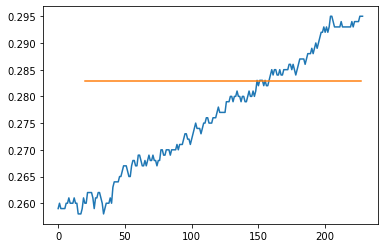

In [109]:
plt.plot(train_data)
plt.plot(range(train_window,train_window+fut_pred),actual_predictions[:,0])

In [110]:
print(train_data[train_window:-1].shape)
print(actual_predictions.shape)
print(MAPE(train_data[train_window:-1], actual_predictions[:]))

(208, 1)
(208, 1)
Resistance    3.632914
dtype: float64


In [111]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_03.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

258
237


ValueError: only one element tensors can be converted to Python scalars

In [112]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_06.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

256
235


ValueError: only one element tensors can be converted to Python scalars

In [113]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_7.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

255
234


ValueError: only one element tensors can be converted to Python scalars

In [114]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_9.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

254
233


ValueError: only one element tensors can be converted to Python scalars

In [ ]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_18.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

In [ ]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_19.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

In [ ]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_20.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

In [ ]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_22.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])

In [ ]:
test_df = pd.read_csv('testset/J0003_0024_0221_20110307012732_cell_23.csv', encoding='utf8')

test_df = test_df['Resistance']
test_data = test_df
test_data = pd.DataFrame(test_data)
test_data.columns = scale_cols
test_data_normalized = scaler.fit_transform(test_data[scale_cols])
test_data_normalized = torch.FloatTensor(test_data_normalized).view(-1)
test_inputs = test_data_normalized[:train_window].tolist()
fut_pred = len(test_data_normalized) - train_window - 1
print(len(test_data_normalized))
print(fut_pred)

for i in range(fut_pred):
    seq = torch.FloatTensor(train_data_normalized[i:i+(train_window)].tolist())
    with torch.no_grad():
        model.hidden = (torch.zeros(1, 1, model.hidden_layer_size), torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())

actual_predictions = scaler.inverse_transform(np.array(test_inputs[train_window:]).reshape(-1,1))

print(MAPE(test_data[train_window:-1], actual_predictions[:]))

plt.plot(test_df)
plt.plot(range(train_window, train_window+fut_pred), actual_predictions[:,0])